# We wish to implement a solver for non-local scalar conservation laws involving the method of characteristics.

A **nonlocal** scalar conservation law has the following form for $\rho : (x,t) \in\mathbb{R}\times [0, +\infty) \mapsto \rho(x,t) \in\mathbb{R}$

\begin{equation}
    \tag{NL-SCL}
    \partial_t \rho + \partial_x (g(\rho)V[\rho](x,t)) = 0 ,
\end{equation}

where typically $V = V_{\omega}$ has a convolution form 

\begin{align*}
V_{\omega}[\rho] (x, t)  & = v(\rho * \omega_{\eta} \,(x,t)) \\ 
            & = v\left(\int_{\mathbb{R}} dy\, \omega_{\eta}(x-y) \rho(y,t) \right),
\end{align*} 

for a suitably smooth kernel $\omega_{\eta} : \mathbb{R} \rightarrow \mathbb{R}$.

In our setting we will assume that $g(\rho) = \rho$ so that the Cauchy problem is 

\begin{equation}
    \begin{cases}
        \partial_t \rho(x,t) + \partial_x (\rho(x,t) \,V_{\omega}[\rho](x,t)) = 0, \quad (x,t) \in \mathbb{R}\times (0,+\infty), \\
        \rho(x,0) = \rho_0(x), \quad x\in \mathbb{R}.
    \end{cases} 
\end{equation}

The existence and unicity of a weak entropy condition  is obtained under the following assumptions (cf. F.A. Chiarello et al. 2020) : 

- $\rho_0 \in \text{BV}(\mathbb{R}, I), \quad I =[\rho_{min}, \rho_{max}].$
- $v \in C^2(I, \mathbb{R}^+), \quad v' \leq 0.$
-  $\omega_{\eta} \in C^1([0,\eta], \mathbb{R}^+), \quad \omega' \leq 0, \quad \int_0^{\eta}\omega_{\eta} = 1, \quad \forall \eta > 0, \, \underset{\eta \rightarrow +\infty}{\lim} \omega_{\eta}(0) = 0.$

In [1]:
import numpy as np 
import matplotlib.pyplot as plt


### Initial condition 

In [2]:
µ_rho = np.pi
sigma_rho = 0.7
rho_0 = lambda x: np.exp(-0.5*(sigma_rho**-2)*(x-µ_rho)**2)

### Chosen Kernel

In [3]:
µ_w = 1
sigma_w = 0.3
w = lambda x: np.exp(-0.5*(sigma_w**-2)*((x-µ_w)**2))

### Velocity

In [4]:
v = lambda x: 1-x

The discretization we introduce is done at first in the Fourier space, as we will need fourier transformations to compute the convolution terms. (cf below) Since we will exploit the FFT algorithm, this means that the fourier space discretization directly implies a real space discretization that we will denote $\{x_j\}_{j = 0, \cdots, N-1}$ 

Let's assume that we computed $\rho^n$ the discrete approximation of $\rho$ at time $t=t^n = n\Delta t$, to obtain $\rho^{n+1}$ we apply the following scheme : 

1) Compute $V^n_{\omega} = V_{\omega}(\rho^n) = v\left(\omega * \rho^n\right) = v(\mathcal{F}^{-1}(\hat{\omega}\,\hat{\rho^n}))\quad$ with $\mathcal{F} = \hat{.}\,$ denoting the Fourier transform.

2) Integrate $\partial_t \rho + V_{\omega}^n \,\partial_x \rho = 0$ analytically with the method of characteristics for linear transport, with $V_{\omega}^n$ as (constant) vector field and $\rho^n$ as initial condition. Namely : $\rho^{n+1}(x_j) = \rho^n(x_j-V_{\omega}^n[j]\Delta t)$

3) Interpolate $\rho^n$ since in all generality the point $x_j - V_{\omega}^n[j]\Delta t$ doesn't belong to the real space grid, and compute $\rho^{n+1}(x_j) \sim \mathcal{I}(\rho^n)(x_j - V_{\omega}^n[j]\Delta t)$, having $\mathcal{I}$ the interpolation operator. 



In [5]:
N = 2**8
x_max = 2*np.pi
x_min = 0
dx = (x_max-x_min)/N 
x = np.array([x_min + j*dx for j in range(N)]) 
rho_zero = np.array(
    list(map(rho_0, x))
)
w_zero = w(x) 

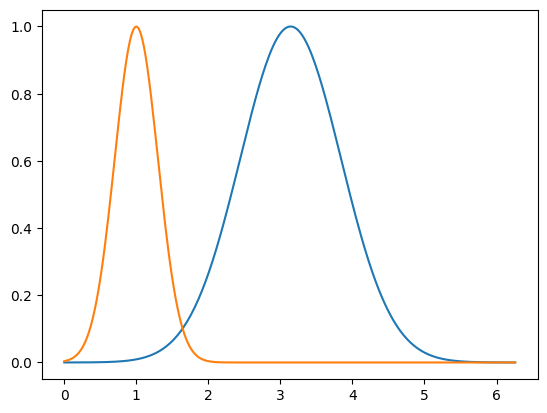

In [6]:
plt.plot(x, rho_zero)
plt.plot(x, w_zero) 

In [7]:
from numpy.fft import fft, ifft, fftshift

In [8]:
rho_hat = fft(rho_zero)
w_hat = fft(w_zero) 

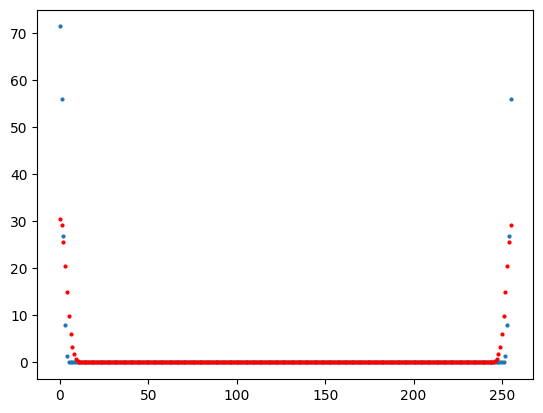

In [9]:
plt.scatter(range(N),(np.abs(rho_hat)), s=4)
plt.scatter(range(N), np.abs(w_hat), s=4, c='red')

In [10]:
convolution_zero = ifft(rho_hat * w_hat)
v_zero = v(np.real(convolution_zero))

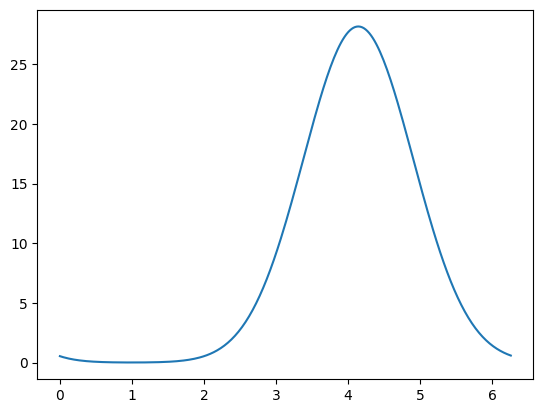

In [11]:
plt.plot(x, np.real(convolution_zero))

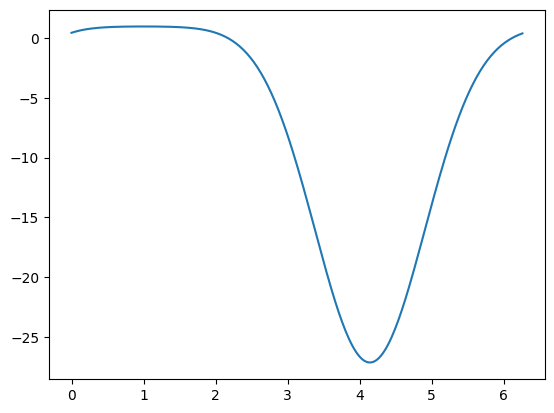

In [12]:
plt.plot(x, v_zero)

In [13]:
def compute_convolution_term(_w, rho_n, v):
    return v(np.real(ifft(fft(_w) * fft(rho_n))))

## Interpolation 

On définit une interpolation en séries de Fourier pour la solution $\rho$. 

In [14]:
def fourier_coeffs(x, k_values, f):
    a = -x[0]
    c = [np.exp(1j*k*a) for k in k_values] * fftshift(fft(f))
    return c  

In [15]:
def fourier_interpolator(x, k_values, c):
    nx = len(x)
    reconstruction = lambda _x: (1/nx) * np.sum(
            [coeff * np.exp(1j*k*_x) for coeff, k in zip(c, k_values)]
        )
    return reconstruction

In [16]:
def fourier_interpol_1D(x, k_values, rho):
    c = fourier_coeffs(x, k_values, rho) 
    s = fourier_interpolator(x, k_values, c) 
    return s 

In [17]:
_N = N//8
_x = np.array(
    [x_min + j*(x_max-x_min)/_N for j in range(_N)]
)


In [18]:
sample = list(map(rho_0, _x)) 

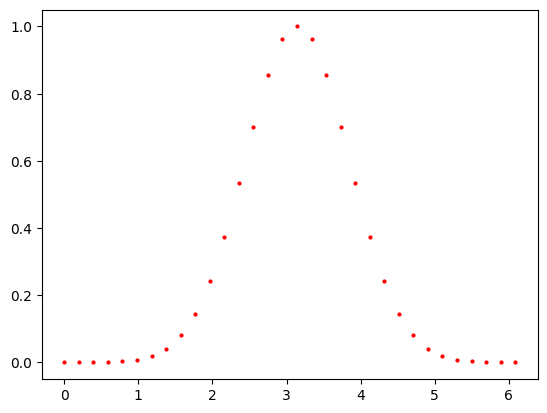

In [19]:
plt.scatter(_x, sample, s=4, c='red')

In [20]:
k_values = np.arange(-_N//2, _N//2)

In [21]:
rho_int = fourier_interpol_1D(_x, k_values, sample)

In [22]:
x[0]

0.0

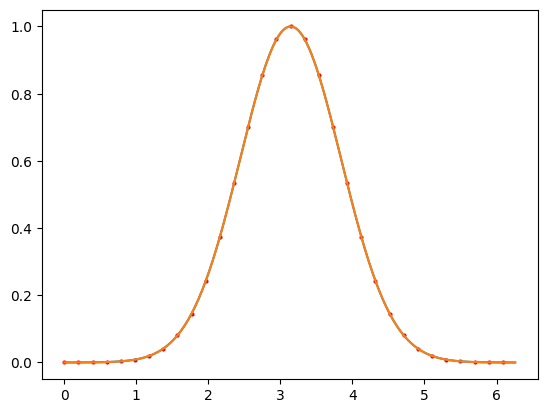

In [23]:
int_values = np.real(np.array(
    list(map(rho_int, x))
))

plt.plot(x,  int_values)
plt.plot(x, list(map(rho_0, x)))
plt.scatter(_x, sample, s=4, c='red')

In [24]:
def solve(x, rho_0, w, v, dt, T):
    N = len(x) 
    solutions = [] 

    ## ------ Init ------ #  
    rho_zero = np.array(
        list(map(rho_0, x))
    )
    solutions.append(rho_zero)
    _w = w(x)
    rho = rho_zero
    print('dt/dx = {}'.format(dt/dx))

    k_values = np.arange(-N//2, N//2)

    ## ---- Iteration --- #
    for _ in range(int(T/dt)):
        _v = compute_convolution_term(_w, rho, v) 

        rho_interpol = fourier_interpol_1D(x, k_values, rho)
        new_rho = np.array([np.real(rho_interpol(x[j] - _v[j]*dt)) for j in range(N)])
        solutions.append(new_rho)
        rho = new_rho 
    
    return solutions 

In [31]:
N = 2**8
x_max = 2*np.pi
x_min = 0
dx = (x_max - x_min)/N 
x = np.array([x_min + j*dx for j in range(N)])

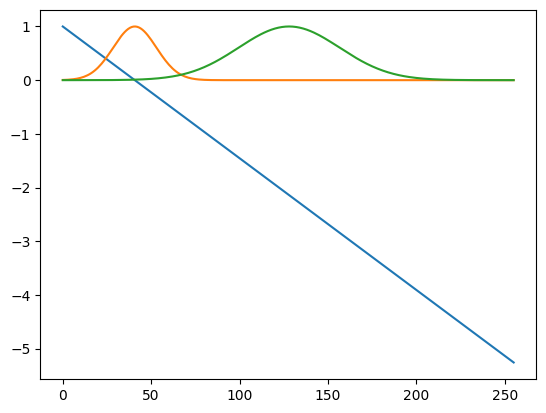

In [32]:
plt.plot(list(map(v,x)))
plt.plot(list(map(w,x)))
plt.plot(list(map(rho_0, x)))

In [33]:
µ_rho = np.pi
sigma_rho = 0.7
rho_0 = lambda x: np.exp(-0.5*(sigma_rho**-2)*(x-µ_rho)**2)

In [62]:
dt = 1e-3
T = 0.5
sol = solve(x, rho_0, w, v, dt, T)

dt/dx = 0.04074366543152521


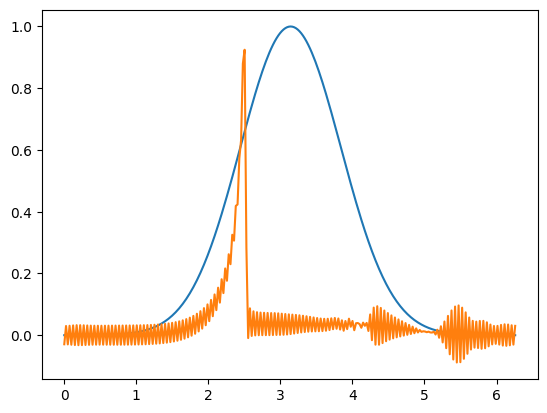

In [63]:
plt.plot(x, rho_zero)
plt.plot(x, sol[-1])

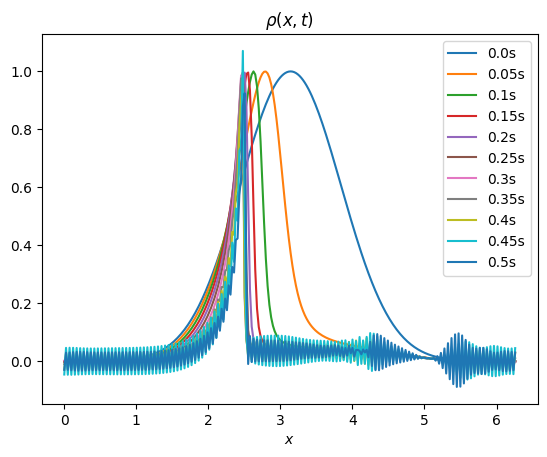

In [65]:
n_curves = 10

for i, rho in enumerate(sol):
    if i%(len(sol)//n_curves)== 0:
        plt.plot(x, rho, label='{}s'.format(round(i*dt,3)))
        plt.xlabel(r'$x$')
        plt.title(r'$\rho(x,t)$')
plt.legend()
plt.savefig('./graphs/gaussian_dx={}_dt={}_T={}.png'.format(round(dx,3), dt,T))